# Coursera Capstone Project
## IBM Data Science Specialization Course in Coursera

Hello everyone! This notebook will be mainly used as a step by step demostration for the IBM Data Science Specialization Capstone Project. To segment Texas counties and cities by its house income, commercial water costs and potential clients search for intersting cities to establish urban agriculture projects.

## Importing Libraries

In [ ]:
# Importing some libraries that will be used. 

# Pandas and Numpy for data exploration
import pandas as pd
import numpy as np  

# Matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Seaborn for visualization
import seaborn as sns

#Folium for mappping
!conda install -c conda-forge folium
import folium

# Sklearn Kmeans for data clustering
from sklearn.cluster import KMeans

In [94]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Importing our Data

### Texas Water Cost
Water is a really important resource for farming, we will use the average Texas Cost by City. I will use a already cleaned up dataset available from my github. The original dataset was published by the Texas Municipal League (https://www.tml.org/), this dataset are the results of the 'Water and Wastewater Rate Survey' for 2019 and we will use the 'Residential and Commercial Water Costs Details'. You can access the original database and more of their results here: https://www.tml.org/229/Water-Wastewater-Survey-Results
The data have the following data:
- City: Texas Cities.
- CityPopulation: Amount of people living in each Texas city.
- TotalCustomers: Total customers reported for residencial and comercial water usage.
- Averageusage: Average monthly residential usage of water.
- 5k Gal: Mean cost in US Dollars per 5000 galons for residential customers
- 10k Gal: Mean cost in US Dollars per 10000 galons for residential customers
- 50k Gal: Mean cost in US Dollars per 50.000 galons for comercial customers
- 200k Gal: Mean cost in US Dollars per 200.000 galons for comercial customers

In [95]:
url_water = 'https://github.com/vidcampos/Coursera_Capstone/raw/master/2019%20water%20fees%20details.xls'
df_water = pd.read_excel(url_water)
df_water.head()

,City,CityPopulation,TotalCustomers,AverageUsage,5k Gal,10k Gal,50k Gal,200k Gal
0,Houston,2312717,486293,6000,30.39,57.31,239.71,920.71
1,Dallas,1341075,334211,8300,18.84,38.84,231.84,839.50
2,Fort Worth,874168,253704,7179,26.85,46.33,244.77,754.10
3,El Paso,683577,213025,5984,25.21,41.72,262.41,1260.26
4,Plano,286143,81346,13290,27.51,46.06,353.04,909.54


### Texas ZIP Codes
We will import the Texas Zip Codes for location segmentation later on the notebook. I will use the data available in my github in excel format but you can access the original data in diferent formats from OpenDataSoft: https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=TX

In [96]:
url_zip = 'https://github.com/vidcampos/Coursera_Capstone/raw/master/Texas%20ZC.xlsx'
df_zip = pd.read_excel(url_zip)
df_zip.drop(inplace=True, columns=['Timezone','Daylight savings time flag','geopoint'])
print(df_zip.shape)
print('Texas Zipcodes were imported correctly')
df_zip.head()

(2743, 5)
Texas Zipcodes were imported correctly


,Zip,City,State,Latitude,Longitude
0,75475,Randolph,TX,33.485315,-96.25525
1,75757,Bullard,TX,32.136787,-95.36710
2,78650,McDade,TX,30.283941,-97.23563
3,75010,Carrollton,TX,33.030556,-96.89328
4,76054,Hurst,TX,32.858398,-97.17681


In [97]:
df_zip['City'].unique

<bound method Series.unique of 0             Randolph
1              Bullard
2               McDade
3           Carrollton
4                Hurst
5          Nacogdoches
6               Energy
7               Lowake
8           Concepcion
9               Wilson
10          Texas City
11             Comfort
12             El Paso
13      Universal City
14          San Isidro
15                Spur
16               Plano
17          Skellytown
18             Houston
19            Pearland
20               Tyler
21          Brownsboro
22              Dallas
23              Temple
24             Houston
25           Galveston
26              Laredo
27           Charlotte
28              Austin
29               Ovalo
             ...      
2713            Athens
2714             Frost
2715             Bryan
2716            Austin
2717           El Paso
2718          Mesquite
2719            Dallas
2720            Spring
2721     West Columbia
2722          New Deal
2723           El Paso
272

Our df_zip dataframe does not have its county added, so we will import a wikipedia table that has some of Texas cities and its corresponding county and merge it into our zipcode table. You can find the original table from wikipedia here: https://en.wikipedia.org/wiki/List_of_cities_in_Texas

In [98]:
# Importing the Wikipedia Table
url_cc = 'https://en.wikipedia.org/wiki/List_of_cities_in_Texas' #
df_cc = pd.read_html(url_cc, header=1)
df_cc  = df_cc[1]
df_cc = df_cc.rename(columns= {'Name': 'City'}) # Renaming the city column
print(df_cc.shape)
df_cc.head(10)

(1115, 2)


,City,County
0,Abbott,Hill
1,Abernathy*,Lubbock
2,Abernathy*,Hale
3,Abilene*,Taylor
4,Abilene*,Jones
5,Ackerly*,Dawson
6,Ackerly*,Martin
7,Addison,Dallas
8,Adrian,Oldham
9,Agua Dulce,Nueces


Our cities by county dataframe (df_cc) probably is not has complete as our zipcode dataframe (df_zip) but it will very useful for our research. Especially beacause it includes many County Seats. However, Let's clean the table because it has some duplicate cities and added characters (like *) into the 'City' column and lets try to adjust to the df_zip shape as much as possible.

In [99]:
df_cc['City'] = df_cc['City'].str.replace('*', '') #Deleting the asterisk
df_cc.head()

,City,County
0,Abbott,Hill
1,Abernathy,Lubbock
2,Abernathy,Hale
3,Abilene,Taylor
4,Abilene,Jones


In [100]:
# Merging both dataframes 
df_zip_merge = df_cc.merge(df_zip, left_on='City', right_on='City', how='inner')
df_zip_merge.drop_duplicates(subset='City', keep='first', inplace=True)
df_zip_merge

,City,County,Zip,State,Latitude,Longitude
0,Abbott,Hill,76621,TX,31.884263,-97.083850
1,Abernathy,Lubbock,79311,TX,33.857895,-101.881560
3,Abilene,Taylor,79602,TX,32.407690,-99.721070
23,Ackerly,Dawson,79713,TX,32.520297,-101.735280
25,Addison,Dallas,75001,TX,32.961290,-96.837510
26,Adrian,Oldham,79001,TX,35.219500,-102.717950
27,Agua Dulce,Nueces,78330,TX,27.782267,-97.901340
28,Alamo,Hidalgo,78516,TX,26.175021,-98.119690
29,Albany,Shackelford,76420,TX,33.036724,-98.595422
31,Aledo,Parker,76008,TX,32.690922,-97.640130


In [101]:
#Cheking is the merge added at least one city per county and city distribution in each county
df_county =df_zip_merge['County'].value_counts()
print(df_county)
print(df_county.head(10))

Hidalgo          17
Collin           16
Tarrant          16
Denton           14
Dallas           14
Brazoria         12
Williamson       12
Harris           12
Fort Bend        11
McLennan         10
Galveston         9
Henderson         9
Grayson           9
Fannin            8
Hunt              8
Johnson           8
Nueces            8
Ellis             7
Bosque            7
Bexar             7
Cameron           7
Jefferson         7
Hill              7
Bowie             6
Guadalupe         6
Liberty           6
Bell              6
San Patricio      6
Lubbock           6
Navarro           6
                 ..
Webb              1
Garza             1
Dallam            1
Ochiltree         1
Kendall           1
San Saba          1
Foard             1
Lee               1
Brooks            1
Maverick          1
Bee               1
Gray              1
San Augustine     1
Kimble            1
Victoria          1
Bailey            1
Hartley           1
Collingsworth     1
Sterling          1


In [102]:
# Checking if NaN's and each column type
df_zip_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762 entries, 0 to 3754
Data columns (total 6 columns):
City         762 non-null object
County       761 non-null object
Zip          762 non-null int64
State        762 non-null object
Latitude     762 non-null float64
Longitude    762 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 41.7+ KB


Merging both datasets added at least one city for all 256 counties, no NaN are present and the datatypes are correct. Merging was done succesfully!

### Texas Income Data
We will use each county Median Household Income of each county. The information was compiled by the The County Information Program, Texas Association of Counties from the U.S. Census Bureau. Small Area Income & Poverty Estimates of 2019. Access data from: https://www.txcip.org/tac/census/morecountyinfo.php?MORE=1013

In [103]:
url_income = 'https://www.txcip.org/tac/census/morecountyinfo.php?MORE=1013' #
df_income = pd.read_html(url_income, header=0)
df_income = df_income[0]
df_income = df_income.rename(columns= {'Median Household Income': 'County', 'Median Household Income.1':'Income'})
print('Importating Texas income data ready!')
df_income.head()

Importating Texas income data ready!


,County,Income
0,Anderson,"$45,969"
1,Andrews,"$84,946"
2,Angelina,"$46,653"
3,Aransas,"$46,912"
4,Archer,"$61,190"


## Exploring the data

### Exploring Water Usage Dataset

In [104]:
df_water.describe()

,CityPopulation,TotalCustomers,AverageUsage,5k Gal,10k Gal,50k Gal,200k Gal
count,6.050000e+02,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000
mean,2.255098e+04,6793.234711,5290.444628,39.427124,63.028314,282.384099,1061.690545
std,1.210872e+05,28947.757700,4192.328519,16.996072,28.911272,183.236281,811.312430
min,5.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.990000e+02,480.000000,3500.000000,28.000000,44.210000,170.000000,615.000000
50%,2.791000e+03,1198.000000,4994.000000,36.450000,59.000000,262.290000,982.500000
75%,1.071200e+04,3750.000000,6198.000000,48.000000,75.470000,375.600000,1419.000000
max,2.312717e+06,486293.000000,48000.000000,137.500000,275.500000,1650.000000,8843.900000


Lets check the count row, we can infer thar the database has information of 650 cities in texas and there are no information for some cities values in all columns (min value of 0) exept in the population column. 
Because we want to start a urban farming company I will focus on the 50k and 200k fess (Comercial fees). We can observe in the table that the mean 50k fee is USD 282 , also that the max cost for 50k is USD 1650, a great diference from the mean value. Regarding population, there are, in average, 22.550 people per city in texas, however 50% of texas cities are not that big, according to the 2 quartile info, half of cities have less or equal than 2791 people there and only 25% of cities in texas that have more than 10 000 citizens (3rd quartile).

We can start filtering cities according to:
1. Let's say we want to build our urban farm in cities over 20.000 citizens more than the 3rd quartile (>10.0000 people): Probably, They would have less farming land and, more likely, will need fresh and affordable veggies to be farmed nearby.
2. Water usage fees are an important cost to consider, so we want to establish an urban farm were water cost are the lowest but, also, there is a good amount if available water. More likely cities with expesive fees will have less resources of water due to the high cost for transporting it or because of water treatement, among others... So, wi will want to establish our urban farm in a city with a average or lower cost (=<$285) for water consumption.

In [105]:
df_water_pop = df_water[df_water['CityPopulation'] > 20000]

In [106]:
df_water_filtered = df_water_pop[df_water_pop['50k Gal'] < 285]
df_water_filtered.head(10)

,City,CityPopulation,TotalCustomers,AverageUsage,5k Gal,10k Gal,50k Gal,200k Gal
0,Houston,2312717,486293,6000,30.39,57.31,239.71,920.71
1,Dallas,1341075,334211,8300,18.84,38.84,231.84,839.50
2,Fort Worth,874168,253704,7179,26.85,46.33,244.77,754.10
3,El Paso,683577,213025,5984,25.21,41.72,262.41,1260.26
5,Laredo,260654,72859,9069,16.71,26.96,215.40,731.49
8,Grand Prairie,193837,48338,9390,35.02,55.22,265.78,940.78
10,Pasadena,153887,35665,7500,20.61,37.30,266.24,963.74
11,Killeen,145482,50547,8000,22.21,38.06,179.82,671.82
13,McAllen,142696,47399,9452,15.20,22.55,75.95,278.45
14,Denton,136268,35947,7117,36.75,57.50,274.00,941.50


In [107]:
print('The minnimum population in the new DF is {}, and the max 50k fee is {}'.format(df_water_filtered['CityPopulation'].min(),
                                                                                      df_water_filtered['50k Gal'].max()))

The minnimum population in the new DF is 21734, and the max 50k fee is 282.7


In [108]:
print('We have filtered from {} cities to just {}.'.format(df_water.shape[0],
                                                           df_water_filtered.shape[0]))

We have filtered from 605 cities to just 43.


## Exploring Texas Income by County

In [109]:
df_income.head()

,County,Income
0,Anderson,"$45,969"
1,Andrews,"$84,946"
2,Angelina,"$46,653"
3,Aransas,"$46,912"
4,Archer,"$61,190"


We have a little problem with this DF income format, looks like we have a $ sign in front of each value, so, probably each value is being consider has a string. Lets check the type 

In [110]:
#Let'ts check the types of each column
df_income.dtypes

County    object
Income    object
dtype: object

Well looks like the Income column is a obj. Lets fixed delete the $ and the comma sign and make our Income column a int.

In [111]:
df_income['Income'] = df_income['Income'].str.replace('$', '')  #Be sure to run the code once with this method.
df_income['Income'] = df_income['Income'].str.replace(',', '')
df_income['Income'] = df_income['Income'].astype(int)
print(df_income.dtypes)
df_income.head()

County    object
Income     int64
dtype: object


,County,Income
0,Anderson,45969
1,Andrews,84946
2,Angelina,46653
3,Aransas,46912
4,Archer,61190


Now let's apply the describe method to the updated dataframe.

In [112]:
df_income.describe()

,Income
count,254.000000
mean,51302.248031
std,12220.163942
min,30076.000000
25%,43253.750000
50%,48541.500000
75%,56199.250000
max,102858.000000


Looks like the mean income for the 650 Texas counties is USD 51.302, also the income ranges from USD 30.076 and USD 102.858. Lets see the  10 cities with the highest and lowest incomes:

In [113]:
#Sort values in descending order.
df_income_sorted = df_income.sort_values(by=['Income'], ascending=False)

# Lets separate the 10 counties with the highest incomes.
highest_income = df_income_sorted.head(10)
highest_income 

,County,Income
198,Rockwall,102858
42,Collin,96936
78,Fort Bend,92310
129,Kendall,90937
35,Chambers,89513
60,Denton,88384
245,Williamson,87817
1,Andrews,84946
86,Glasscock,83330
164,Midland,80189


[Text(0.5, 1.0, '10 Texas Counties with the Highest Income')]

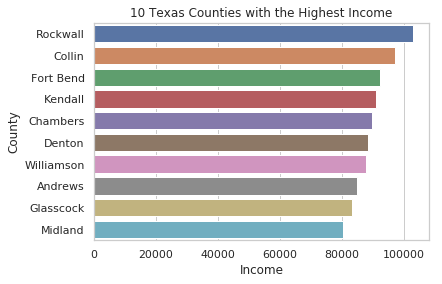

In [114]:
#Visualazing the highest incomes counties.
sns.set(style="whitegrid")
ax = sns.barplot(x="Income", y="County", data=highest_income)
ax.set(title='10 Texas Counties with the Highest Income')

In [115]:
#Now lets see the 10 counties with the lowest incomes.
lowest_income = df_income_sorted.tail(10)
lowest_income 

,County,Income
123,Jim Hogg,36176
163,Menard,35881
161,Maverick,35594
65,Duval,35156
244,Willacy,33171
252,Zapata,33160
95,Hall,32597
213,Starr,30490
23,Brooks,30116
253,Zavala,30076


[Text(0.5, 1.0, '10 Texas Counties with lowest income')]

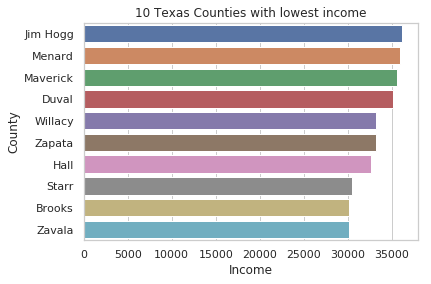

In [116]:
sns.set(style="whitegrid")
ax = sns.barplot(x="Income", y="County", data=lowest_income)
ax.set(title='10 Texas Counties with lowest income')

Urban farming is not cheap. Cultivating in control enviroments is kinda expensive depending the techonolgy we want to apply and the agricultural practices the farmer apply. So one would guess that cities with highest avegerage income would be more better for selling our veggies, right? 

Well we cannot assumed that just by the mean income of each household in a certain area, other variables have to be taken into consideration, for example, how many potential potential clients are around bussiness, lets say we will sell to people directly  or other bussiness (such as restaurants, supermarkets, cafes). For now, lets filter the counties that have incomes over the 3rd quartile, arround USD 56.500, they are above the average and see if they fit the water costs and population parameters as well.

We will merge the other tables we have (zipcodes and water cost and population) to start zooming in the best Counties and top cities afterwards that fits into our parameters.

In [117]:
# Creating a dataframe with incomes over $56.500
df_income_filtered = df_income[df_income['Income'] > 56500]
print('We have created a DF where the incomes ranges from USD {} to USD {}.'.format(df_income_filtered['Income'].min(), 
                                                                                    df_income_filtered['Income'].max()))

We have created a DF where the incomes ranges from USD 56556 to USD 102858.


In [118]:
df_income_filtered.head()

,County,Income
1,Andrews,84946
4,Archer,61190
5,Armstrong,57210
7,Austin,59942
10,Bastrop,61883


## Merging Dataframes

### Merging Zipcodes and Income dataframes

We will first merge the df_zip_merge that contains the zipcodes and locations of the each city and county with the df_income_filtered dataframe that contains al the Counties with incomes over USD 56.500.

In [119]:
df_merge = df_income_filtered.merge(df_zip_merge, left_on='County', right_on='County', how='right')
print('Merge donde succesfully') # Can check if there is just 1 zipcode per city to verify inner merge where done right.
df_merge.head()

Merge donde succesfully


,County,Income,City,Zip,State,Latitude,Longitude
0,Andrews,84946.0,Andrews,79714,TX,32.345871,-102.56767
1,Archer,61190.0,Archer City,76351,TX,33.574426,-98.63462
2,Archer,61190.0,Holliday,76366,TX,33.760814,-98.72148
3,Archer,61190.0,Scotland,76379,TX,33.646685,-98.48719
4,Archer,61190.0,Windthorst,76389,TX,33.554607,-98.42076


In [120]:
df_all = df_merge.merge(df_water_filtered, left_on='City', right_on='City', how='inner')
df_all.dropna(inplace=True) 
print("We have a filtered database with {} results.".format(df_all.shape[0]))
df_all

We have a filtered database with 20 results.


,County,Income,City,Zip,State,Latitude,Longitude,CityPopulation,TotalCustomers,AverageUsage,5k Gal,10k Gal,50k Gal,200k Gal
0,Brazoria,74225.0,Lake Jackson,77566,TX,29.036879,-95.441030,27604,9061,5800,26.40,47.90,248.40,968.40
1,Collin,96936.0,Allen,75013,TX,33.106582,-96.694020,100685,31488,10000,34.20,54.20,245.65,760.15
2,Comal,76523.0,New Braunfels,78135,TX,29.738502,-98.087157,79152,39285,6500,20.55,33.53,153.41,537.56
3,Dallas,59838.0,Coppell,75099,TX,32.771030,-96.799630,41941,13398,10000,33.60,49.35,213.94,686.44
4,Dallas,59838.0,Dallas,75294,TX,32.767268,-96.777626,1341075,334211,8300,18.84,38.84,231.84,839.50
5,Dallas,59838.0,Duncanville,75138,TX,32.767268,-96.777626,39826,12626,0,29.04,51.11,260.31,1077.81
6,Dallas,59838.0,Grand Prairie,75050,TX,32.759922,-97.012160,193837,48338,9390,35.02,55.22,265.78,940.78
7,Denton,88384.0,Carrollton,75010,TX,33.030556,-96.893280,135710,39577,8250,23.36,40.06,158.92,505.42
8,Denton,88384.0,Denton,76204,TX,33.207430,-97.116282,136268,35947,7117,36.75,57.50,274.00,941.50
9,Galveston,71959.0,Friendswood,77546,TX,29.516873,-95.194720,39839,12978,10000,21.30,35.80,189.95,624.95


# Clustering the best cities

We will use cluster k means to cluster alike citie based on the Income, City Population, Water Cost for 50k gallons and City population. This will help us to filter even more our cities that fit the best our parameters and, later on, we will seek th potential customers to get the final conclusions.

In [121]:
# First we will extract the columns to make the clustering and visualize the mean results.

# DataFrame to see the mean results
viz_data = df_all[["City", "County","Income", "CityPopulation", "50k Gal"]] 

# Preparing the DF for fitting.
cluster_list = ["Income", "CityPopulation", "50k Gal"]
df_cluster = df_all[cluster_list]
df_cluster.head()

,Income,CityPopulation,50k Gal
0,74225.0,27604,248.40
1,96936.0,100685,245.65
2,76523.0,79152,153.41
3,59838.0,41941,213.94
4,59838.0,1341075,231.84


In [122]:
# Lets normalize the data
from sklearn.preprocessing import StandardScaler

X = df_cluster.values
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 0.31325642, -0.47952316,  0.3946562 ],
       [ 2.24362311, -0.34939882,  0.3239408 ],
       [ 0.5085795 , -0.38773939, -2.04798216],
       [-0.90959531, -0.45399542, -0.491472  ],
       [-0.90959531,  1.85917691, -0.03117906],
       [-0.90959531, -0.45776128,  0.70091815],
       [-0.90959531, -0.18353708,  0.8415775 ],
       [ 1.51672883, -0.28703508, -1.90629422],
       [ 1.51672883, -0.28604153,  1.05295225],
       [ 0.12065323, -0.45773813, -1.1083674 ],
       [ 0.2825725 , -0.47524628,  1.04240922],
       [-0.87534153, -0.46832884,  0.27688292],
       [-0.87534153,  3.58923355,  0.17119555],
       [-0.87534153, -0.25467003,  0.85340626],
       [ 0.59995127, -0.37843424,  1.27667004],
       [-1.16373632, -0.33459355, -1.8535791 ],
       [-0.38082902, -0.48117907,  0.54225851],
       [-0.38082902,  1.02782591,  0.30131187],
       [-0.38082902, -0.43255582, -0.76250483],
       [ 1.46853554, -0.30845865,  0.4231995 ]])

In [123]:
# Fitting Kmeans
num_clusters = 3 #Lets say we want a top 3 similar cities.

k_means = KMeans(init="k-means++", n_clusters=num_clusters, random_state=0)
k_means.fit(cluster_dataset)
labels = k_means.labels_

In [124]:
viz_data["Labels"] = labels
viz_data.groupby('Labels').mean()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Income,CityPopulation,50k Gal
Labels,,,
0,73185.545455,8.643036e+04,260.376364
1,62046.000000,1.509320e+06,238.773333
2,69935.166667,7.660400e+04,180.098333


In the previous table we can get the averages of each parameter was choosen. We can visualize separated information to take a decision of wich cluster to choose.

## Visualizing Cluster 0

In [125]:
viz_data0 =viz_data[viz_data['Labels'] == 0]
print("This cluster has a income between USD {}-{},a population between {}-{} citizens and a water cost between USD {}-{}.".format(viz_data0["Income"].min(),
                                                                                                                             viz_data0["Income"].max(),
                                                                                                                             viz_data0["CityPopulation"].min(),
                                                                                                                             viz_data0["CityPopulation"].max(),
                                                                                                                            viz_data0["50k Gal"].min(),
                                                                                                                             viz_data0["50k Gal"].max(),))
viz_data0

This cluster has a income between USD 59838.0-96936.0,a population between 26674-193837 citizens and a water cost between USD 243.82-282.7.


,City,County,Income,CityPopulation,50k Gal,Labels
0,Lake Jackson,Brazoria,74225.0,27604,248.40,0
1,Allen,Collin,96936.0,100685,245.65,0
5,Duncanville,Dallas,59838.0,39826,260.31,0
6,Grand Prairie,Dallas,59838.0,193837,265.78,0
8,Denton,Denton,88384.0,136268,274.00,0
10,Seguin,Guadalupe,73864.0,30006,273.59,0
11,Deer Park,Harris,60241.0,33891,243.82,0
13,Pasadena,Harris,60241.0,153887,266.24,0
14,Conroe,Montgomery,77598.0,84378,282.70,0
16,Colleyville,Tarrant,66059.0,26674,254.14,0


## Visualizing Cluster 1

In [126]:
viz_data1 =viz_data[viz_data['Labels'] == 1]
print("This cluster has a income between USD {}-{},a population between {}-{} citizens and a water cost between USD {}-{}.".format(viz_data1["Income"].min(),
                                                                                                                             viz_data1["Income"].max(),
                                                                                                                             viz_data1["CityPopulation"].min(),
                                                                                                                             viz_data1["CityPopulation"].max(),
                                                                                                                            viz_data1["50k Gal"].min(),
                                                                                                                             viz_data1["50k Gal"].max(),))
viz_data1

This cluster has a income between USD 59838.0-66059.0,a population between 874168-2312717 citizens and a water cost between USD 231.84-244.77.


,City,County,Income,CityPopulation,50k Gal,Labels
4,Dallas,Dallas,59838.0,1341075,231.84,1
12,Houston,Harris,60241.0,2312717,239.71,1
17,Fort Worth,Tarrant,66059.0,874168,244.77,1


## Visualizing Cluster 2

In [127]:
viz_data2 =viz_data[viz_data['Labels'] == 2]
print("This cluster has a income between USD {}-{},a population between {}-{} citizens and a water cost between USD {}-{}.".format(viz_data2["Income"].min(),
                                                                                                                             viz_data2["Income"].max(),
                                                                                                                             viz_data2["CityPopulation"].min(),
                                                                                                                             viz_data2["CityPopulation"].max(),
                                                                                                                            viz_data2["50k Gal"].min(),
                                                                                                                             viz_data2["50k Gal"].max(),))
viz_data2

This cluster has a income between USD 56848.0-88384.0,a population between 39839-135710 citizens and a water cost between USD 153.41-213.94.


,City,County,Income,CityPopulation,50k Gal,Labels
2,New Braunfels,Comal,76523.0,79152,153.41,2
3,Coppell,Dallas,59838.0,41941,213.94,2
7,Carrollton,Denton,88384.0,135710,158.92,2
9,Friendswood,Galveston,71959.0,39839,189.95,2
15,Tyler,Smith,56848.0,109000,160.97,2
18,Grapevine,Tarrant,66059.0,53982,203.40,2


- Cluster 0 is a more heterogenous cluster, Incomes, Population intervals are really far from each other, also have the cities with the most expensive water prices.

- Cluster 1 incomes are between USD 60k, it has  average water prices and the highest populations.

- Cluster 2 have medium-high incomes, heterogenous intervals regarding population and the cheapest water prices.

Cluster 2 looks like the best choice because have a balance between all our parameters. So lets check how many potential clients are in those cities using the Foursquare API.

## Potential Clients using Foursquare API.

Finaly, we will use Foursquare API to look for potential clients in each city and observe wich city have more clients in a 10 km radiums. We will filter our search adding a "Food" category and a "Food and Beverages Stores" wich are the clients could potentially bought our products the most. For more about FourSquare categories https://developer.foursquare.com/docs/resources/categories.

### Settling our Final Dataframe

In [128]:
# Settling up a new dataframe with all cities wich are labeled as cluster 2.
df_all["Labels"] = labels
final_df = df_all
final_df.drop(columns=["TotalCustomers", "AverageUsage", "5k Gal", "10k Gal", "200k Gal","State"], inplace=True)
final_df = final_df[final_df['Labels'] == 2].reset_index(drop=True)
final_df

,County,Income,City,Zip,Latitude,Longitude,CityPopulation,50k Gal,Labels
0,Comal,76523.0,New Braunfels,78135,29.738502,-98.087157,79152,153.41,2
1,Dallas,59838.0,Coppell,75099,32.771030,-96.799630,41941,213.94,2
2,Denton,88384.0,Carrollton,75010,33.030556,-96.893280,135710,158.92,2
3,Galveston,71959.0,Friendswood,77546,29.516873,-95.194720,39839,189.95,2
4,Smith,56848.0,Tyler,75712,32.411237,-95.289903,109000,160.97,2
5,Tarrant,66059.0,Grapevine,76099,32.771419,-97.291484,53982,203.40,2


Lets see where our top 6 cities are between texas using folium.

In [129]:
# Configuring the Foursquare API
LIMIT = 2000 # Lets limit our search to 2000 places per city
CLIENT_ID = 'YOUR CLIENT' # Add your Foursquare ID here
CLIENT_SECRET = 'YOUR SECRET' #Add your Foursquare Secret Here
FOOD_ID= "4d4b7105d754a06374d81259"
MARKET_ID= "4bf58dd8d48988d1f9941735"
VERSION = '20200101'

In [130]:
import requests
from pandas.io.json import json_normalize 

# Defining a function to extract the venues
def NearbyVenues(names, latitudes, longitudes, radius=5000): #By default limits the search in 5 km.
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            FOOD_ID,
            MARKET_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [131]:
# Making a new dataframe with the venues data
cities_venues = NearbyVenues(names=final_df['City'],
                                   latitudes=final_df['Latitude'],
                                   longitudes=final_df['Longitude']) # Defining venues in a 400m radius

New Braunfels
Coppell
Carrollton
Friendswood
Tyler
Grapevine


In [132]:
print(cities_venues.shape)
cities_venues.head()

(221, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New Braunfels,29.738502,-98.087157,Orange Leaf Frozen Yogurt,29.728971,-98.074255,Food & Drink Shop
1,New Braunfels,29.738502,-98.087157,HEB Plus New Braunfels,29.731804,-98.077662,Grocery Store
2,New Braunfels,29.738502,-98.087157,Spec's,29.724805,-98.074219,Liquor Store
3,New Braunfels,29.738502,-98.087157,"Gruene, Texas Market Day",29.739743,-98.102403,Farmers Market
4,New Braunfels,29.738502,-98.087157,Winery on the Gruene,29.739052,-98.105162,Wine Shop


In [133]:
# Lets see all Venues from our Top cities.

from folium import plugins

# Texas latitude and longitude
TX_lat = 30.7721261
TX_lon = -96.8638765
zoom = 7

all_map = folium.Map(location=[TX_lat, TX_lon], zoom_start=zoom)


# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(all_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label in zip(cities_venues["Venue Latitude"],cities_venues["Venue Longitude"], cities_venues["Venue"]):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup= label
    ).add_to(incidents)

# display map
all_map

In [134]:
# Potential Customers nearby top 3 cities
customers = cities_venues.groupby('City')['Venue'].nunique().to_frame()
customers

,Venue
City,
Carrollton,37
Coppell,87
Friendswood,18
Grapevine,37
New Braunfels,16


Looks like Coppel, Grapevine and Carollton have the most clients nearby in a 5km radius

## Mapping Coppell Venues Distribution

We can map, for example, Carrollton Venues to see the distribution around the city and the specific category of each venue. This can be done with each city.

In [135]:
# Separing Carrollton venues into a DF.
coppell_df= cities_venues[cities_venues["City"] == "Coppell"]
coppell_df.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
16,Coppell,32.77103,-96.79963,Union Station Wolfgang Puck,32.776111,-96.807497,Food & Drink Shop
17,Coppell,32.77103,-96.79963,Whole Foods Market,32.795804,-96.801602,Grocery Store
18,Coppell,32.77103,-96.79963,7-Eleven,32.767818,-96.836189,Convenience Store
19,Coppell,32.77103,-96.79963,Royal Blue Grocery,32.780995,-96.796994,Grocery Store
20,Coppell,32.77103,-96.79963,Tom Thumb,32.789158,-96.806689,Grocery Store


In [136]:
# Texas latitude and longitude
Cop_lat = 32.7721261
Cop_lon = -96.8638765
zoom = 12

loc_map = folium.Map(location=[Cop_lat, Cop_lon], zoom_start=zoom)

# instantiate a feature group for the incidents in the dataframe
venues = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(coppell_df["City Latitude"], coppell_df["City Longitude"]):
    venues.add_child(
        folium.features.Marker(
            [lat, lng],
            fill=True,
            fill_color='red',
        )
    )

# add pop-up text to each marker on the map
latitudes = list(coppell_df["Venue Latitude"])
longitudes = list(coppell_df["Venue Longitude"])
labels = list(coppell_df["Venue"])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(loc_map)    
    
# add incidents to map
loc_map.add_child(venues)

### Making a Conclusion table

We will merge the final_df and the potential customers to make a resume table.

In [137]:
#Reset customers index
customers.reset_index(inplace=True)

#Merging the tables
conclusions = final_df.merge(customers, left_on='City', right_on='City', how='inner')

#Renaming the Columns
conclusions = conclusions.rename(columns={"Venue": "Clients Nearby", 
                                          "CityPopulation":"Population", 
                                          "50k Gal": "Water Cost", 
                                          "Income":"County Income"})

# Dropping other columns than the ones with our filter variables
conclusions.drop(columns=["Zip", "Latitude", "Longitude", "Labels"], inplace=True)
conclusions

,County,County Income,City,Population,Water Cost,Clients Nearby
0,Comal,76523.0,New Braunfels,79152,153.41,16
1,Dallas,59838.0,Coppell,41941,213.94,87
2,Denton,88384.0,Carrollton,135710,158.92,37
3,Galveston,71959.0,Friendswood,39839,189.95,18
4,Tarrant,66059.0,Grapevine,53982,203.40,37


In [138]:
# Changing columns order.
income = conclusions["County Income"]
conclusion_df = conclusions[["County", "City", "Population", "Water Cost", "Clients Nearby"]]
conclusion_df.insert(2, "County Income", income)

#Sorting in descending order by Clients Nearby
conclusion_df.sort_values(by="Clients Nearby", ascending=False, inplace=True)
conclusion_df.reset_index(drop=True)

,County,City,County Income,Population,Water Cost,Clients Nearby
0,Dallas,Coppell,59838.0,41941,213.94,87
1,Denton,Carrollton,88384.0,135710,158.92,37
2,Tarrant,Grapevine,66059.0,53982,203.40,37
3,Galveston,Friendswood,71959.0,39839,189.95,18
4,Comal,New Braunfels,76523.0,79152,153.41,16


# Conclusions

1. Coppell City in Dallas County could be a great city to establish the Urban Farm beacuse it have a >20.000 population, Water Cost under the average in Texas a County Average Income over 75% of other Texas Counties and also have 87 potential bussiness clients categorized as Groceries Stores and Restaurantes nearby in a 5 km radius.
2. Carrollton in Denton Conunty and Graprevine in Tarrant County also met all previous requirements but did not have as mich near by potential clients as Coppell who almost doubled this cities.

# Acknowledgement

This project was made by David Campos as part of the IBM Data Science Specialization Final Capstone Project in Coursera, you can find this project resume at my github: https://github.com/vidcampos.